<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/7_analyze_wave_with_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install netcdf4

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [4]:
#Read in data frame of annotation features

features_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
#check for missing values
if annot_features_full.isnull().sum().sum() > 0:
  print('You have missing values in your data frame')
else:
  print('Your data frame is complete')
annot_features_full.head()

(959, 13)
Your data frame is complete


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341


In [5]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             animal_number                                                             power_sum                                                                                               spec_cent                                                                                                   spec_kurt                                                                              spec_pur                                                                       spec_roll                                                                                                   spec_skew                                                                       spec_slope                                                                       spec_spread                                                                                                        time_stamp                                                                \
                count        mean         std   min     25%    50%     75%    max         count        mean        std    min     25%    50%     75%    max     count           mean            std        min          25%          50%           75%          max     count          mean           std           min           25%           50%           75%           max     count       mean        std        min        25%        50%        75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max     count      mean       std       min       25%       50%       75%       max      count      mean       std       min       25%       50%       75%       max       count           mean            std           min           25%            50%            75%            max      count           mean            std      min         25%        50%   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
bbc              45.0   94.533333   55.230756   2.0   37.00  110.0  145.00  157.0          45.0  547.022222  12.083966  527.0  535.00  554.0  557.00  559.0      45.0  187049.752200  163252.249644  51008.836  108528.2660  142034.1900  185542.44000    872012.60      45.0  32096.112594   3592.063646  25317.517312  30090.095178  31762.963636  34324.170621  41218.670832      45.0  14.507654   8.570242   1.158310  10.448164  13.066885  18.996466  34.298438     45.0  0.135980  0.063951  0.026119  0.091080  0.126480  0.173507  0.306177      45.0  30491.306964   3412.460464  24051.641447  28585.590419  30174.815454  32607.962090  39157.737290      45.0  3.616554  1.064733  1.420153  3.056477  3.603695  4.080782  5.614859       45.0 -0.002336  0.000402 -0.002793 -0.002664 -0.002428 -0.002093 -0.001040        45.0  106052.164971   57973.683260  22861.514782  68103.292456   95060.654641  149716.189200  272975.403907       45.0  203221.000000  163944.266043  13590.0   60570.000  174352.50   
high multi        4.0   89.500000  

In [0]:
def annotations_to_classes_df(dataframe, annot_dic):
  """takes in dataframe of computed slice features and a dictonary containing the annotation classes as keys and 
  annotation names as values (you will need to create this) and generates a new dataframe specific to the dic"""

  i = 0
  annot_features_classes = pd.DataFrame()
  while i < len(annot_dic):
    annot_df = dataframe[dataframe['Annotation'] == annot_dic[i]]
    annot_df['class'] = i
    annot_features_classes = pd.concat([annot_features_classes, annot_df], axis = 0)
    i = i + 1
    
  return annot_features_classes
                         

In [8]:
#create dictionary containing annotation types and corresponding class variable that you wish to use for model generation
annot_dic = {0: 'rand_noise', 1: 'bbc'}

annot_features_classes = annotations_to_classes_df(annot_features_full, annot_dic)
print(annot_features_classes.shape)
print(annot_features_classes['Annotation'].value_counts())
annot_features_classes.head()

(845, 14)
rand_noise    800
bbc            45
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class
159,0,527,cagepair,461835.0,rand_noise,44678.920,0.350064,30627.099129,2956.536556,0.721131,0.455487,0.000358,29095.744172,0
160,1,527,cagepair,203377.5,rand_noise,41862.957,0.281023,24936.175583,25642.704254,6.340334,43.543729,-0.000934,23689.366803,0
161,2,527,cagepair,121567.5,rand_noise,46037.652,0.180324,21605.548489,7977.768396,3.113229,13.136537,-0.001138,20525.271064,0
162,3,527,cagepair,85567.5,rand_noise,44034.360,0.327318,28406.047238,2184.235031,0.683441,1.515507,0.000231,26985.744876,0
163,4,527,cagepair,289777.5,rand_noise,39228.720,0.361183,33185.533433,2784.000929,0.500232,1.094987,0.000529,31526.256761,0


In [10]:
#separate and save features for train and test sets
test_features = annot_features_classes[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
print(test_features.shape)
test_class = annot_features_classes['class']
print(test_class.shape)
test_features.head()

(845, 8)
(845,)


,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
159,44678.920,0.350064,30627.099129,2956.536556,0.721131,0.455487,0.000358,29095.744172
160,41862.957,0.281023,24936.175583,25642.704254,6.340334,43.543729,-0.000934,23689.366803
161,46037.652,0.180324,21605.548489,7977.768396,3.113229,13.136537,-0.001138,20525.271064
162,44034.360,0.327318,28406.047238,2184.235031,0.683441,1.515507,0.000231,26985.744876
163,39228.720,0.361183,33185.533433,2784.000929,0.500232,1.094987,0.000529,31526.256761


In [0]:
# center and scale the data for test set
scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features)

In [27]:
#load saved model
!cd '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/pickled_models'

pkl_filename = "svm_trained_pickle_model.pkl" 
trained_model = pickle.load(open(pkl_filename, 'rb'))
trained_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
#test model using test data
print("score: ", trained_model.score(test_features_scaled, test_class))
test_pred_svm = trained_model.predict(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
print("ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_svm[:,1]))
confusion_matrix(test_class, test_pred_svm)

0.7183431952662722
              precision    recall  f1-score   support

           0       1.00      0.70      0.83       800
           1       0.15      0.96      0.27        45

   micro avg       0.72      0.72      0.72       845
   macro avg       0.58      0.83      0.55       845
weighted avg       0.95      0.72      0.80       845



array([[564, 236],
       [  2,  43]])

In [30]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(test_class, test_pred_svm))
print("Precision (PPV): ", metrics.precision_score(test_class, test_pred_svm))
print("Accuracy: ", metrics.accuracy_score(test_class, test_pred_svm))
print("F1:", metrics.f1_score(test_class, test_pred_svm))

Sensitivity/Recall (TPR):  0.9555555555555556
Precision (PPV):  0.15412186379928317
Accuracy:  0.7183431952662722
F1: 0.26543209876543206


In [0]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_rf[:,1]))

Logistic regression ROC_AUC:  0.9779775099142909
Random forest ROC_AUC:  0.9763131222497163
SVM ROC_AUC:  0.984248346354397


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

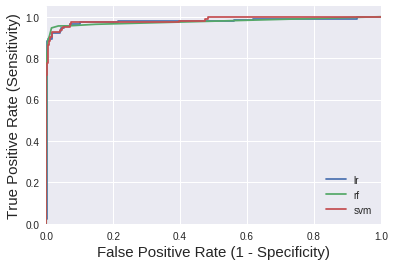

In [0]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(train_class_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(train_class_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(train_class_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

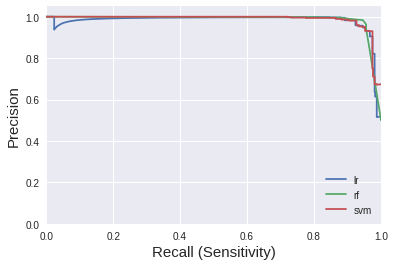

In [0]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(train_class_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(train_class_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(train_class_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

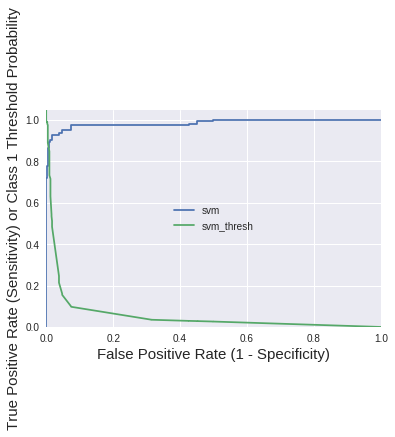

In [0]:
# plot best model with thresholds
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_svm, thresholds_svm, label="svm_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [0]:
#create new columns for each model's pred prob and the best model's pred class
train_upsamples['pred_prob_lr'] = y_pred_prob_lr[:,1]
train_upsamples['pred_prob_rf'] = y_pred_prob_rf[:,1]
train_upsamples['pred_prob_svm'] = y_pred_prob_svm[:,1]
train_upsamples['class_svm'] = y_pred_svm
train_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_svm
78,78,A6,D3,162517.5,BBC,68156.440,0.187200,31514.690472,85639.593214,3.589622,12.904453,-0.002214,29938.955948,1,0.996178,1.0,1.000000,1
124,124,A12,D3,152032.5,BBC,27928.262,0.304314,39094.049942,173179.208219,5.095447,26.057127,-0.001720,37139.347444,1,0.999755,1.0,0.962105,1
62,62,A4,D3,185287.5,BBC,81081.190,0.189197,31584.553143,93767.091005,6.058342,41.135769,-0.002127,30005.325486,1,0.998089,1.0,0.990050,1
70,70,A4,D3,296685.0,BBC,80507.370,0.111275,30258.227260,121942.846727,4.239221,18.490913,-0.002610,28745.315897,1,0.999111,1.0,0.999999,1
154,154,A10,D4,242347.5,BBC,77760.880,0.146432,24225.699985,20037.851443,2.133710,4.169034,-0.001984,23014.414986,1,0.684735,0.9,0.974899,1


In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
preds = []
for index, row in train_upsamples.iterrows():
    if (row['class'] == 0) & (row['class_svm'] == 0):
        pred = 'TN'
    if (row['class'] == 0) & (row['class_svm'] == 1):
        pred = 'FP'
    if (row['class'] == 1) & (row['class_svm'] == 1):
        pred = 'TP'
    if (row['class'] == 1) & (row['class_svm'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_upsamples['pred'] = preds
train_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_svm,pred
78,78,A6,D3,162517.5,BBC,68156.440,0.187200,31514.690472,85639.593214,3.589622,12.904453,-0.002214,29938.955948,1,0.996178,1.0,1.000000,1,TP
124,124,A12,D3,152032.5,BBC,27928.262,0.304314,39094.049942,173179.208219,5.095447,26.057127,-0.001720,37139.347444,1,0.999755,1.0,0.962105,1,TP
62,62,A4,D3,185287.5,BBC,81081.190,0.189197,31584.553143,93767.091005,6.058342,41.135769,-0.002127,30005.325486,1,0.998089,1.0,0.990050,1,TP
70,70,A4,D3,296685.0,BBC,80507.370,0.111275,30258.227260,121942.846727,4.239221,18.490913,-0.002610,28745.315897,1,0.999111,1.0,0.999999,1,TP
154,154,A10,D4,242347.5,BBC,77760.880,0.146432,24225.699985,20037.851443,2.133710,4.169034,-0.001984,23014.414986,1,0.684735,0.9,0.974899,1,TP


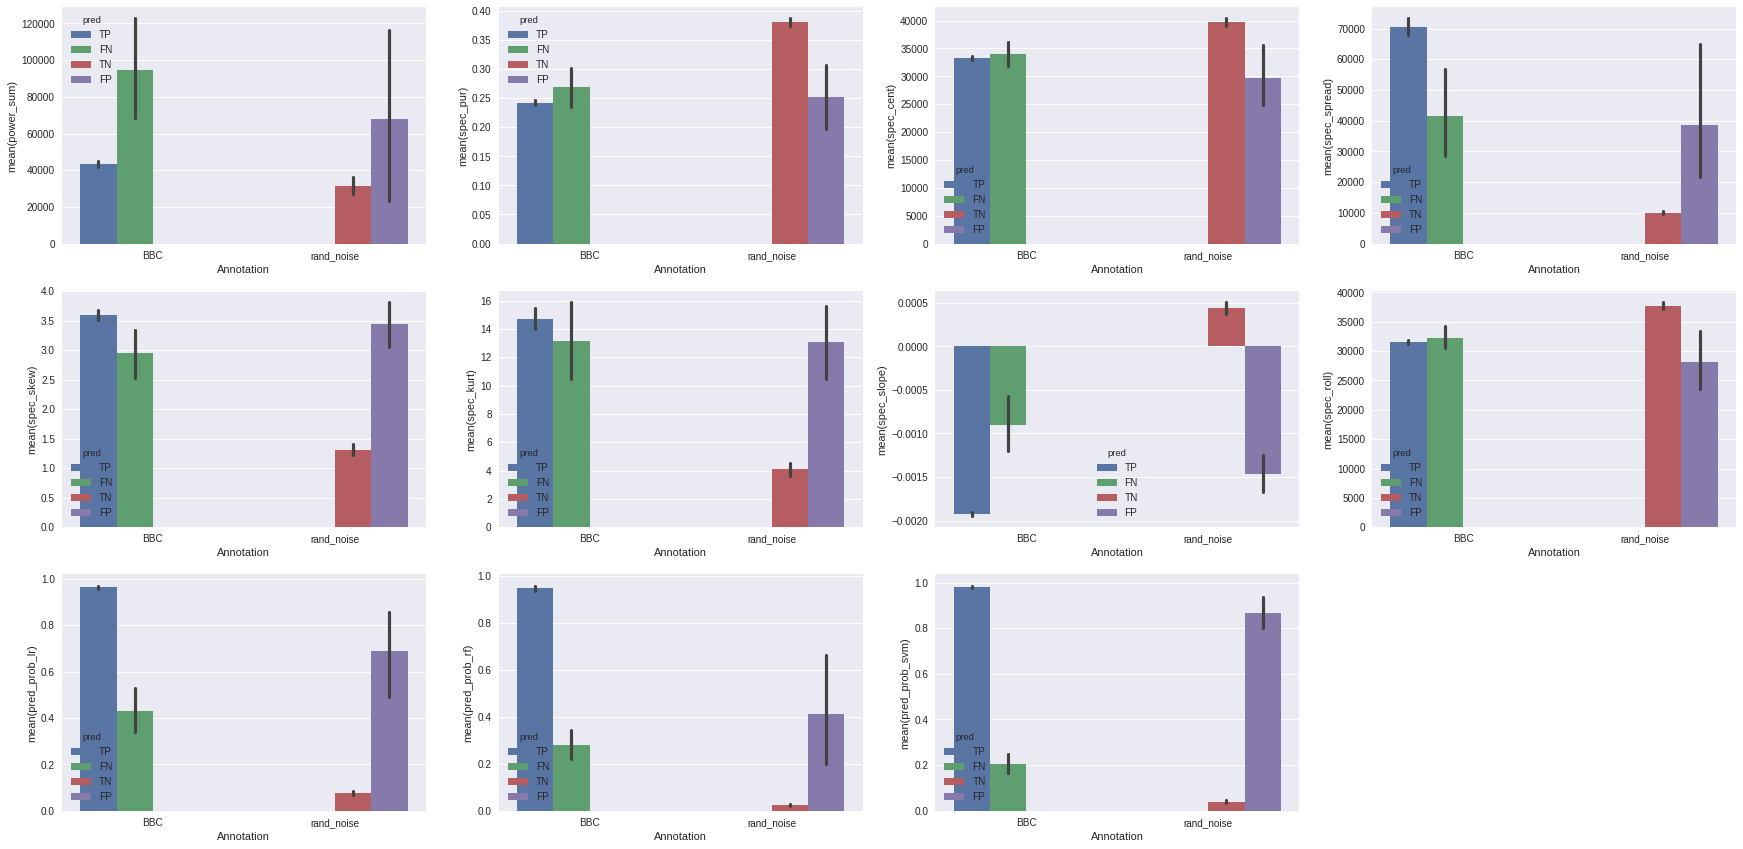

In [0]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_lr', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_upsamples)
    i = i + 1

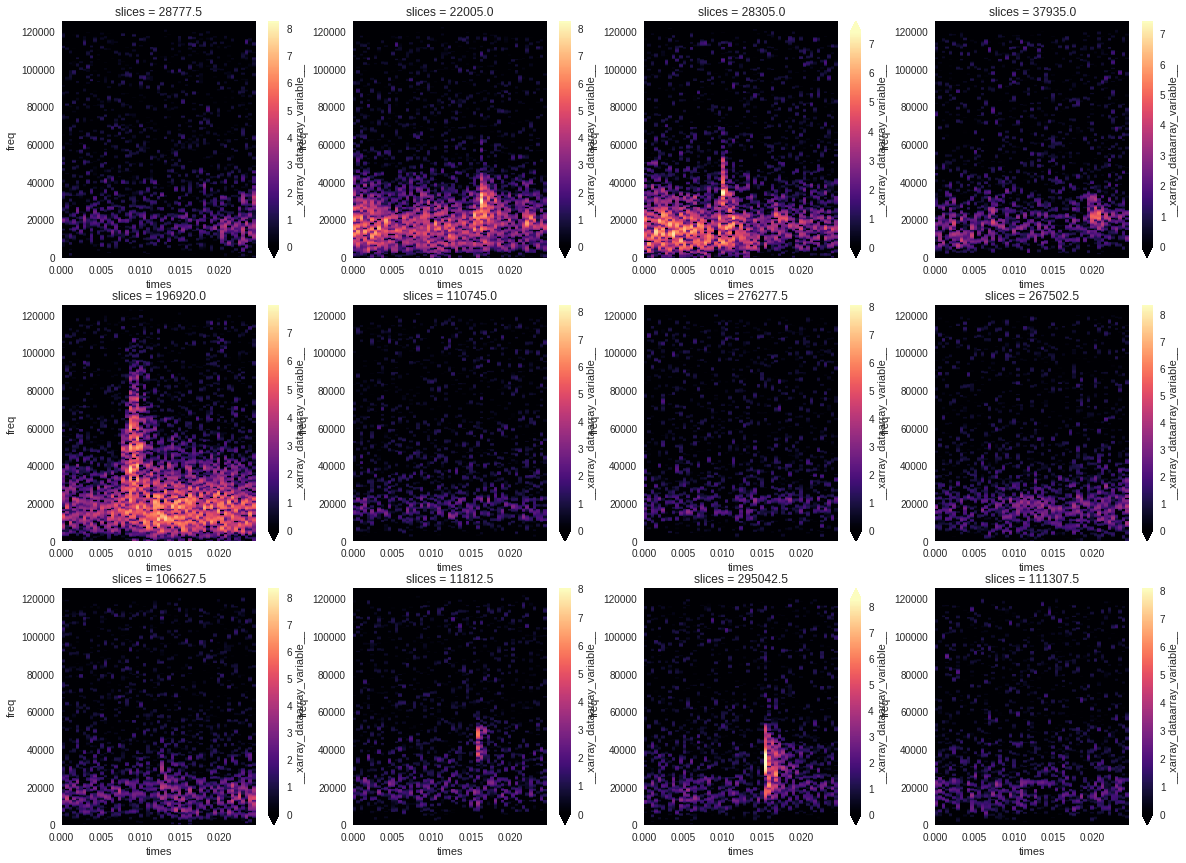

In [0]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

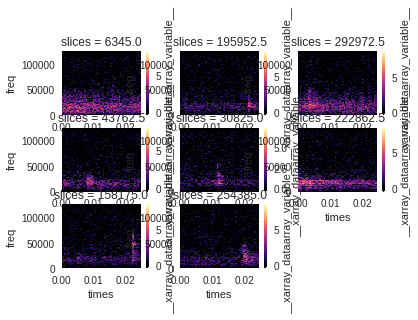

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [0]:
#once you have decided on the model and hyperparameters, fit the model using the train data
svm_cv.fit(train_features_scaled, train_class_up) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
#pickel model to save for later use
!cd '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/pickled_models'

pkl_filename = "svm_trained_pickle_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [0]:
#test model using test data
print(svm_cv.score(test_features_scaled, test_class))
test_pred_svm = svm_cv.predict(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
confusion_matrix(test_class, test_pred_svm)

0.8024691358024691
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       271
           1       0.45      0.91      0.60        53

   micro avg       0.80      0.80      0.80       324
   macro avg       0.71      0.84      0.73       324
weighted avg       0.89      0.80      0.82       324



array([[212,  59],
       [  5,  48]])

In [0]:
import pickle
svm_trained_model = pickle.dumps(svm_cv)